In [6]:
%pip install esig
%pip install contourpy 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import copy
import numpy as np
import esig
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

Loaded intel_openmp/libiomp5md.dll from C:\Users\User\OneDrive\Desktop\Imperial\ImperialProjects\Stats\venv\Library\bin\libiomp5md.dll


# Function for Converting Price Paths to Lead-Lag Paths and Signature

In [4]:
def path_to_sig(paths, method=''):
    times = np.repeat(np.linspace(0, 1, paths.shape[1]), 2)[:-1]
    lead_lags = []
    sigs = []
    depth = 4
    for path in paths:
        temp = np.repeat(path[:, None], 2, axis=0)
        lead_lag = np.hstack((times[:, None], np.hstack((temp, np.vstack((temp[1:], [0]))))[:-1]))
        lead_lags.append(lead_lag)
        sig = esig.stream2sig(lead_lag, depth)
        sigs.append(sig)

    return lead_lags, sigs

# Lead-Lag Illustration with Black-Scholes Paths

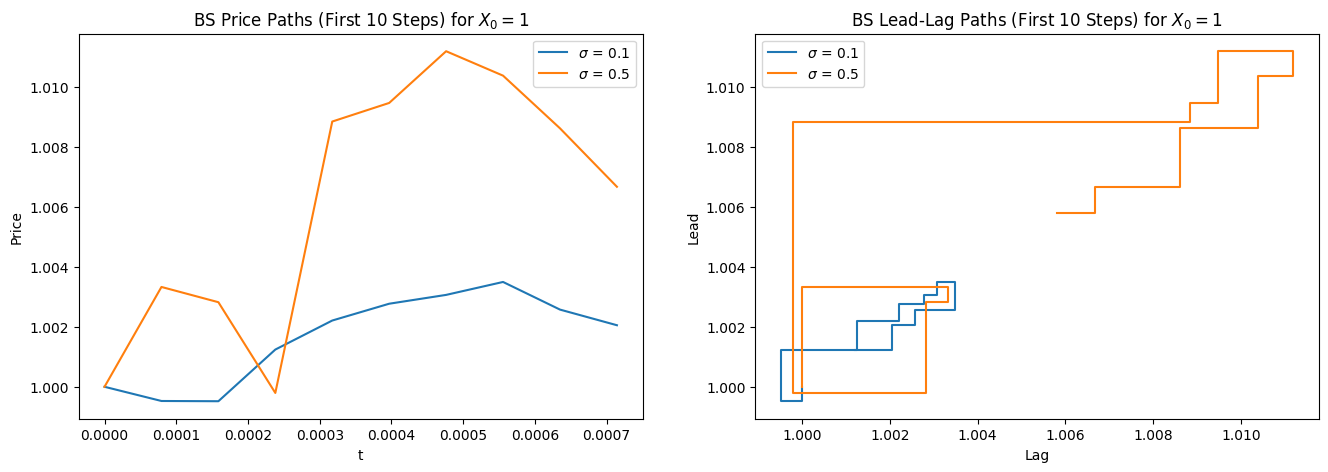

In [5]:
r = 0.045
paths = []
steps = 252*50
h = 1/steps
vols = [0.1, 0.5]
for vol in vols:
    increments = np.hstack((np.ones((5, 1)), np.exp((r-0.5*(vol**2))*h + vol*np.random.normal(loc=0, scale=np.sqrt(h), size=(5, steps)))))
    St = increments.cumprod(axis=1)
    paths.append(St)
S_t = np.vstack(paths).T

BS_lead_lag, BS_signatures = path_to_sig(S_t.T)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
for i in range(2):
    path = S_t[:, 5 * i]
    axs[0].plot(np.linspace(0, 1, len(path))[:10], path[:10], label=rf'$\sigma$ = {np.round(vols[i], 2)}')
axs[0].set_xlabel('t')
axs[0].set_ylabel('Price')
axs[0].set_title(r'BS Price Paths (First 10 Steps) for $X_0 = 1$')
axs[0].legend()

for i in range(2):
    lead_lag = BS_lead_lag[5*i]
    axs[1].plot(lead_lag[:21, 1], lead_lag[:21, 2], label=rf'$\sigma$ = {np.round(vols[i], 2)}')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Lead')
axs[1].set_title(r'BS Lead-Lag Paths (First 10 Steps) for $X_0 = 1$')
axs[1].legend();

# Calibrating Heston Model to Market Data

### Pre-processing market options data

In [6]:
ndx = pd.read_excel('./Data/NASDAQ.xlsx')    # NASDAQ market data
s0 = ndx.loc[ndx['Date'] == '06/21/2023', 'Close'].values[0]
r = 0.045    #Approximately equal to the interest rate during the time period of the data

ndx_opt = pd.read_csv('./Data/NASDAQ Options.csv')
ndx_opt.drop(['symbol', 'optionid', 'contract_size', 'index_flag', 'issuer', 'exercise_style'], axis=1, inplace=True)
ndx_opt['strike_price'] /= 1000
ndx_opt = ndx_opt.dropna(subset=['last_date']).reset_index(drop=True)
ndx_opt = ndx_opt[((ndx_opt['cp_flag'] == 'C') & (ndx_opt['strike_price'] > s0*np.exp(r))) |
                  ((ndx_opt['cp_flag'] == 'P') & (ndx_opt['strike_price'] < s0*np.exp(r)))]
for col in ['date', 'exdate', 'last_date']:
    ndx_opt[col] = pd.to_datetime(ndx_opt[col], format='%m/%d/%Y')
def last_trade_diff_days(row):
    return (row['date']-row['last_date']).days
ndx_opt.loc[:, 'last_trade_diff_days'] = ndx_opt.apply(last_trade_diff_days, axis=1)
ndx_opt = ndx_opt[ndx_opt['last_trade_diff_days'] < 9].reset_index(drop=True)
# Converting put to call prices
def put_to_call(row, col):
    if row['cp_flag'] == 'P':
        return row[col]+s0-row['strike_price']*np.exp(-r)
    else:
        return row[col]

ndx_opt['best_bid'] = ndx_opt.apply(put_to_call, args=('best_bid',), axis=1)
ndx_opt['best_offer'] = ndx_opt.apply(put_to_call, args=('best_offer',), axis=1)
ndx_opt.loc[:, 'mid'] = (ndx_opt['best_bid'] + ndx_opt['best_offer'])/2
ndx_opt.drop(['cp_flag', 'last_trade_diff_days'], axis=1, inplace=True)
ndx_opt = ndx_opt.sort_values(by='strike_price').reset_index(drop=True)
ndx_opt.to_pickle('./Data/ndx_opt')

ndx_opt = pd.read_pickle('./Data/ndx_opt')
print(ndx_opt)

         date     exdate  last_date  strike_price     best_bid   best_offer          mid
0  2023-06-21 2024-06-21 2023-06-20        9600.0  5798.574174  5815.874174  5807.224174
1  2023-06-21 2024-06-21 2023-06-20       11000.0  4555.477700  4576.377700  4565.927700
2  2023-06-21 2024-06-21 2023-06-20       11200.0  4382.778203  4403.678203  4393.228203
3  2023-06-21 2024-06-21 2023-06-21       11500.0  4127.478959  4147.078959  4137.278959
4  2023-06-21 2024-06-21 2023-06-21       11800.0  3874.679714  3894.479714  3884.579714
5  2023-06-21 2024-06-21 2023-06-15       12100.0  3624.280470  3645.180470  3634.730470
6  2023-06-21 2024-06-21 2023-06-15       13400.0  2592.083743  2619.483743  2605.783743
7  2023-06-21 2024-06-21 2023-06-21       13700.0  2369.484499  2397.284499  2383.384499
8  2023-06-21 2024-06-21 2023-06-20       14000.0  2153.785254  2183.285254  2168.535254
9  2023-06-21 2024-06-21 2023-06-13       14200.0  2014.085758  2043.985758  2029.035758
10 2023-06-21 2024-06

### Defining useful functions for the analytical computation of the Heston price

In [9]:
def heston_cf(w, s0, v0, vbar, a, vvol, r, rho, t, K):
    alpha = -(w**2)/2 - w*1j/2
    beta = a - rho * vvol * w*1j
    gamma = (vvol**2)/2
    h = np.sqrt(beta**2 - 4 * alpha * gamma)
    r_plus = (beta + h) / (vvol**2)
    r_minus = (beta - h) / (vvol**2)
    g = r_minus/r_plus

    C = a * (r_minus*t - (2/(vvol**2))*np.log((1-g*np.exp(-h*t))/(1-g)))
    D = r_minus * (1-np.exp(-h*t))/(1-g*np.exp(-h*t))
    return np.exp(C * vbar + D * v0 + w * 1j * np.log(s0 * np.exp(r * t)))


def heston_integrand1(w, s0, v0, vbar, a, vvol, r, rho, t, K):
    integrand1 = np.exp(-w*np.log(K)*1j)*heston_cf(w-1j, s0, v0, vbar, a, vvol, r, rho, t, K)
    integrand1 /= w*heston_cf(-1j, s0, v0, vbar, a, vvol, r, rho, t, K)*1j
    return integrand1.real


def heston_integrand2(w, s0, v0, vbar, a, vvol, r, rho, t, K):
    integrand2 = np.exp(-w * np.log(K) * 1j) * heston_cf(w, s0, v0, vbar, a, vvol, r, rho, t, K)
    integrand2 /= w*1j
    return integrand2.real


def heston_price(s0, v0, vbar, a, vvol, r, rho, t, K):
    quad1 = quad(heston_integrand1, 0, 1000, args=(s0, v0, vbar, a, vvol, r, rho, t, K), limit=500)
    quad2 = quad(heston_integrand2, 0, 1000, args=(s0, v0, vbar, a, vvol, r, rho, t, K), limit=500)
    pi1 = 0.5 + (1/np.pi)*quad1[0]
    pi2 = 0.5 + (1/np.pi)*quad2[0]
    return s0*pi1 - K*np.exp(-r*t)*pi2

# Mean squared objective to minimise
def objective(v0, vbar, a, vvol, rho):
    fitted_prices = np.array([heston_price(s0, v0, vbar, a, vvol, r, rho, 1, K) for K in ndx_opt['strike_price']])
    prices = ndx_opt['mid'].values
    return ((fitted_prices-prices)**2).mean()

### Minimise mean squared objective

(Don't run the next block)

In [ ]:
range_constraint = [[0.01, 0.2], [0.01, 0.1], [0, 10], [0, 1], [-1, 0]]
trials = 10
d = {}
# Initialising random points to try and find global minimum
for _ in range(trials):
    init_vals = np.random.uniform(size=5)*np.array([0.19, 0.009, 10, 1, -1])
    init_vals[0] += 0.01
    init_vals[1] += 0.01
    least_squares = minimize(lambda y: objective(*y), x0=init_vals, method='L-BFGS-B',
                             options={'disp': True}, bounds=range_constraint, tol=1e-6)
    v0, vbar, a, vvol, rho = least_squares.x
    ndx_opt.loc[:, 'heston_price'] = np.array([heston_price(s0, v0, vbar, a, vvol, r, rho, 1, K) for K in ndx_opt['strike_price']])
    percentage_fitted = len(ndx_opt[(ndx_opt['heston_price'] > ndx_opt['best_bid']) &
                                    (ndx_opt['heston_price'] < ndx_opt['best_offer'])])/len(ndx_opt)
    d[tuple(least_squares.x)] = [least_squares.fun, percentage_fitted]

### Calibrated parameters:
v0, vbar, a, vvol, rho = (0.03581466309771346, 0.07407797025112246, 2.046494577628063, 0.8616517094046003, -0.5474954924526506)

Mean half-spread:  20.815999999999963
Mean absolute deviation:  14.2485995619309


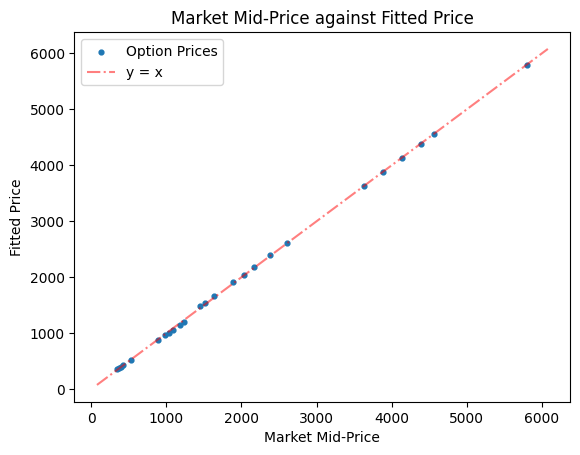

In [22]:
v0, vbar, a, vvol, rho = (0.03581466309771346, 0.07407797025112246, 2.046494577628063, 0.8616517094046003, -0.5474954924526506)
plt.scatter(ndx_opt['mid'].values, np.array([heston_price(s0, v0, vbar, a, vvol, r, rho, 1, K) for K in ndx_opt['strike_price']]), s=12)
(x1, x2) = plt.gca().get_xlim()
plt.plot([x1, x2], [x1, x2], linestyle='-.', c='r', alpha=0.5)
plt.title('Market Mid-Price against Fitted Price')
plt.ylabel('Fitted Price')
plt.xlabel('Market Mid-Price')
plt.legend(['Option Prices', 'y = x'])
ndx_opt.loc[:, 'heston_price'] = np.array([heston_price(s0, v0, vbar, a, vvol, r, rho, 1, K) for K in ndx_opt['strike_price']])
print('Mean half-spread: ', np.mean(np.abs(ndx_opt['best_bid']-ndx_opt['best_offer']))/2)
print('Mean absolute deviation: ', np.mean(np.abs(ndx_opt['heston_price']-ndx_opt['mid'])))

# Generating Heston Price Paths

In [25]:
def generate_correlated_brownian_increments(rho, steps, num_paths, dt):
    np.random.seed(0)
    dW1 = np.random.normal(loc=0, scale=np.sqrt(dt), size=(steps, num_paths))
    dW2 = np.random.normal(loc=0, scale=np.sqrt(dt), size=(steps, num_paths))
    dW2 = rho * dW1 + np.sqrt(1 - rho ** 2) * dW2
    return dW1, dW2

(Don't run the next block if you already have ./Data/ in directory)

In [23]:
steps = 252*20
dt = 1/steps
num_paths = 50000

dW1, dW2 = generate_correlated_brownian_increments(rho, steps, num_paths, dt)
v_t = np.ones((steps+1, num_paths))*v0
S_t = np.ones((steps+1, num_paths))
for i in range(1, steps+1):
    v_t[i, :] = np.abs((a*(vbar-v_t[i-1, :])*dt + vvol*np.sqrt(v_t[i-1, :])*dW2[i-1, :]) + v_t[i-1, :])
    S_t[i, :] = r*S_t[i-1, :]*dt + np.sqrt(v_t[i-1, :])*S_t[i-1, :]*dW1[i-1, :] + S_t[i-1, :]

np.save('./Stats/dfs/Heston v_t', v_t)
np.save('./Stats/dfs/Heston S_t', S_t)
del v_t, S_t

### Computing price of derivatives using discounted average payoff

(Don't run the next block if you already have ./Data/ in directory)

In [26]:
S_t = np.load('./Data/Heston S_t.npy')
max_S = S_t.max(axis=0)
avg = S_t.mean(axis=0)
european = {}
up_and_in = {}
up_and_out = {}
variance_option = {}
asian_option = {}

for strike in np.linspace(1, 1.48, 25):
    payoffs = np.maximum(S_t[-1, :]-strike, 0)
    european[strike] = (payoffs.mean())/(1+r)
for barrier in np.linspace(1.1, 1.3, 5):
    for strike in np.linspace(barrier-0.4, barrier-0.32, 5):
        pos_payoffs = S_t[-1, (max_S > barrier) & (S_t[-1, :] > strike)]
        up_and_in[(barrier, strike)] = ((pos_payoffs-strike).mean())*(len(pos_payoffs)/num_paths)/(1+r)
for barrier in np.linspace(1.4, 1.6, 5):
    for strike in np.linspace(barrier - 0.6, barrier - 0.52, 5):
        pos_payoffs = S_t[-1, (max_S < barrier) & (S_t[-1, :] > strike)]
        up_and_out[(barrier, strike)] = ((pos_payoffs-strike).mean())*(len(pos_payoffs)/num_paths)/(1+r)
log_ret = np.log(S_t[1:, :]/S_t[:-1, :])
realised_variance = (log_ret**2).sum(axis=0)
# Variance option on 10 notional
for variance in np.linspace(0.001, 0.025, 25):
    variance_option[variance] = ((np.maximum(realised_variance-variance, 0)*10).mean())/(1+r)
# Asian option
for strike in np.linspace(0.70, 1.19, 50):
    payoffs = np.maximum(avg - strike, 0)
    asian_option[strike] = (payoffs.mean())/(1+r)

european_df = pd.DataFrame(data=[european]).T
up_and_in_df = pd.DataFrame(data=[up_and_in]).T
up_and_out_df = pd.DataFrame(data=[up_and_out]).T
variance_option_df = pd.DataFrame(data=[variance_option]).T
asian_option_df = pd.DataFrame(data=[asian_option]).T

european_df.index = ['E' + str(round(elem, 2)) for elem in european_df.index]
up_and_in_df.index = ['IN' + str(round(elem[0], 2)) + ':' + str(round(elem[1], 2)) for elem in up_and_in_df.index]
up_and_out_df.index = ['OUT' + str(round(elem[0], 2)) + ':' + str(round(elem[1], 2)) for elem in up_and_out_df.index]
variance_option_df.index = ['V' + str(round(elem, 3)) for elem in variance_option_df.index]
asian_option_df.index = ['AS' + str(round(elem, 2)) for elem in asian_option_df.index]

market = pd.concat([european_df, up_and_in_df, up_and_out_df, variance_option_df])
del european, up_and_in, up_and_out, variance_option
del european_df, up_and_in_df, up_and_out_df, variance_option_df, S_t, log_ret, realised_variance
market = market.rename(columns={0: 'price'})
asian_option_df = asian_option_df.rename(columns={0: 'price'})

market.to_pickle('./Stats/dfs/Market')
asian_option_df.to_pickle('./Stats/dfs/Asian_Prices')

These are the 'market' prices we will use from now on

In [30]:
market = pd.read_pickle('./Data/Market')
asian_option_df = pd.read_pickle('./Data/Asian_Prices')
print(market.head())
print(asian_option_df.head())

          price
E1.0   0.111286
E1.02  0.099545
E1.04  0.088496
E1.06  0.078206
E1.08  0.068689
           price
AS0.7   0.310598
AS0.71  0.301206
AS0.72  0.291839
AS0.73  0.282498
AS0.74  0.273183


# Generating Black Scholes Price Paths and Signatures

(Don't run the next block if you already have ./Data/ in directory) \
__It takes >15 mins__

In [ ]:
paths = []
steps = 252*50
h = 1/steps
vols = np.linspace(0.05, 0.4, 100)
for vol in vols:
    increments = np.hstack((np.ones((100, 1)), np.exp((r-0.5*(vol**2))*h + vol*np.random.normal(loc=0, scale=np.sqrt(h), size=(100, steps)))))
    St = increments.cumprod(axis=1)
    paths.append(St)
S_t = np.vstack(paths).T

start = time.time()
BS_lead_lag, BS_signatures = path_to_sig(S_t.T)
print(time.time()-start)
BS_signatures = pd.DataFrame(BS_signatures)
BS_signatures.index.name = 'Path'
BS_signatures.columns.name = 'Signature'
BS_signatures.to_pickle('./Stats/dfs/BS_signatures')
pd.DataFrame(S_t).to_pickle('./Stats/dfs/BS_St')

In [58]:
BS_signatures = pd.read_pickle('./Data/BS_signatures')
print('Signature min:', BS_signatures.min().min(), ', max:', BS_signatures.max().max())
S_t = pd.read_pickle('./Data/BS_St').to_numpy()
avg = S_t.mean(axis=0)
max_S = S_t.max(axis=0)
temp = copy.deepcopy(BS_signatures)

# Dropping columns that are multiples of each other (by construction)
drop_columns = [0, 1, 4, 13, 40]
temp.drop(temp.columns[drop_columns], axis=1, inplace=True)

# Normalisation
temp = temp - temp.min(axis=0)
temp = 2*np.divide(temp, temp.max(axis=0)) - 1

Signature min: -0.8264460664301504 , max: 3.461156720257999


# Computing Signature Payoffs

### Removing columns with high correlation

In [59]:
upper = np.triu(np.corrcoef(temp.T))
remove = set([])
for i in range(temp.shape[1]-1):
    if i in remove:
        continue
    for j in range(i+1, temp.shape[1]):
        if upper[i][j] > 0.99:
            remove.add(j)

temp.drop(temp.columns[list(remove)], axis=1, inplace=True)
temp = pd.concat([pd.Series([1.0]*10000, name=0), temp], axis=1)
temp

,0,2,5,7,8,9,11,14,16,17,18,20,22,23,25,26,27,28,29,30,34,35,36,38,41,43,44,45,47,49,50,52,53,54,55,56,57,61,62,63,65,67,68,70,71,72,74,76,77,79,80,81,82,83,84,85,86,88,89,90,91,92,103,104,106,109
0,1.0,-0.517345,-0.495483,-0.414917,-0.999883,-0.892814,-0.999837,-0.349489,-0.385952,-0.999673,-0.814704,-0.999712,-0.320169,-0.551800,-0.999986,-0.931731,-0.821145,-0.906484,-0.939899,-0.934631,-0.999983,-0.929378,-0.789408,-0.936946,-0.264340,-0.389706,-0.999550,-0.778789,-0.999589,-0.363698,-0.411402,-0.999887,-0.883032,-0.668460,-0.841045,-0.920368,-0.909447,-0.999946,-0.805621,-0.589548,-0.918515,-0.260543,-0.436784,-0.577025,-0.872593,-0.705523,-0.888183,-1.000000,-0.472659,-0.891881,-1.000000,-0.709501,-0.882491,-0.999705,-0.992785,-0.890335,-0.482312,-0.907593,-0.822526,-0.586844,-0.902823,-0.979678,-1.000000,-0.465055,-0.883044,-0.872764
1,1.0,-0.513259,-0.468665,-0.437058,-0.999951,-0.892859,-0.999922,-0.315151,-0.395631,-0.999833,-0.814841,-0.999878,-0.346703,-0.552172,-0.999468,-0.931730,-0.821126,-0.905886,-0.939934,-0.934655,-0.999551,-0.929357,-0.789369,-0.936959,-0.227324,-0.379603,-0.999719,-0.778940,-0.999757,-0.391215,-0.411857,-0.999319,-0.883025,-0.668443,-0.840318,-0.920410,-0.909491,-0.999530,-0.805580,-0.589497,-0.918515,-0.283175,-0.437132,-0.577191,-0.872610,-0.705510,-0.888218,-0.999207,-0.472644,-0.891892,-1.000000,-0.709501,-0.882465,-0.999704,-0.992785,-0.889452,-0.482336,-0.907621,-0.822526,-0.586845,-0.902822,-0.979677,-0.999321,-0.465009,-0.883065,-0.872755
2,1.0,-0.508910,-0.458417,-0.439904,-0.999992,-0.892866,-0.999989,-0.314528,-0.363901,-0.999710,-0.814674,-0.999799,-0.366247,-0.552381,-0.999443,-0.931730,-0.821124,-0.905782,-0.939943,-0.934664,-0.999596,-0.929349,-0.789360,-0.936960,-0.232339,-0.351357,-0.999724,-0.778921,-0.999781,-0.358701,-0.411357,-0.999606,-0.883022,-0.668471,-0.840559,-0.920381,-0.909488,-0.999833,-0.805578,-0.589518,-0.918491,-0.316114,-0.437467,-0.578125,-0.872617,-0.705496,-0.888238,-0.998531,-0.472641,-0.891891,-1.000000,-0.709501,-0.882438,-0.999704,-0.992784,-0.888630,-0.482332,-0.907674,-0.822526,-0.586845,-0.902863,-0.979677,-0.998803,-0.465006,-0.883031,-0.872689
3,1.0,-0.439876,-0.410185,-0.355484,-0.996163,-0.889014,-0.996362,-0.268189,-0.337602,-0.996223,-0.811116,-0.996641,-0.259889,-0.548344,-0.996784,-0.931568,-0.821016,-0.903161,-0.939770,-0.934534,-0.997010,-0.929160,-0.789220,-0.936763,-0.183769,-0.330903,-0.996082,-0.775254,-0.996483,-0.328972,-0.409632,-0.997511,-0.882880,-0.668343,-0.838521,-0.920280,-0.909397,-0.997818,-0.805408,-0.589360,-0.918348,-0.200560,-0.432509,-0.574595,-0.872400,-0.705372,-0.887970,-0.996330,-0.472535,-0.891753,-0.999993,-0.709495,-0.882436,-0.999699,-0.992781,-0.886545,-0.482274,-0.907455,-0.822519,-0.586839,-0.902748,-0.979672,-0.996607,-0.464862,-0.882873,-0.872649
4,1.0,-0.449376,-0.425362,-0.357432,-0.997189,-0.890090,-0.997295,-0.292419,-0.318524,-0.997274,-0.812263,-0.997534,-0.271974,-0.549934,-0.996595,-0.931628,-0.821084,-0.902975,-0.939815,-0.934586,-0.996826,-0.929228,-0.789292,-0.936816,-0.215600,-0.309852,-0.997898,-0.777204,-0.998030,-0.313247,-0.410030,-0.996162,-0.882925,-0.668418,-0.836988,-0.920271,-0.909410,-0.996685,-0.805473,-0.589447,-0.918369,-0.219578,-0.435251,-0.573958,-0.872509,-0.705491,-0.888069,-0.996980,-0.472602,-0.891734,-0.999996,-0.709499,-0.882392,-0.999700,-0.992783,-0.887258,-0.482319,-0.907478,-0.822523,-0.586843,-0.902757,-0.979674,-0.997172,-0.464947,-0.882832,-0.872579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,-0.290163,-0.293889,-0.185652,-0.958974,-0.927529,-0.894295,-0.224904,-0.080158,-0.939262,-0.874696,-0.848537,-0.145996,-0.563733,-0.917923,-0.926055,-0.839615,-0.935135,-0.922674,-0.938619,-0.826936,-0.915858,-0.796355,-0.913337,-0.160700,-0.201

Signature payoffs min: -0.06952503630589435 , max:  0.6429344751350206
Signature payoffs min: -0.09865231996381527 , max:  0.9122897437666766
Signature payoffs min: -0.08894322540905364 , max:  0.8225046542015662
Signature payoffs min: -817.8665546105426 , max:  768.494154365414
Signature payoffs min: -0.060225659813823995 , max:  0.5569382633852911


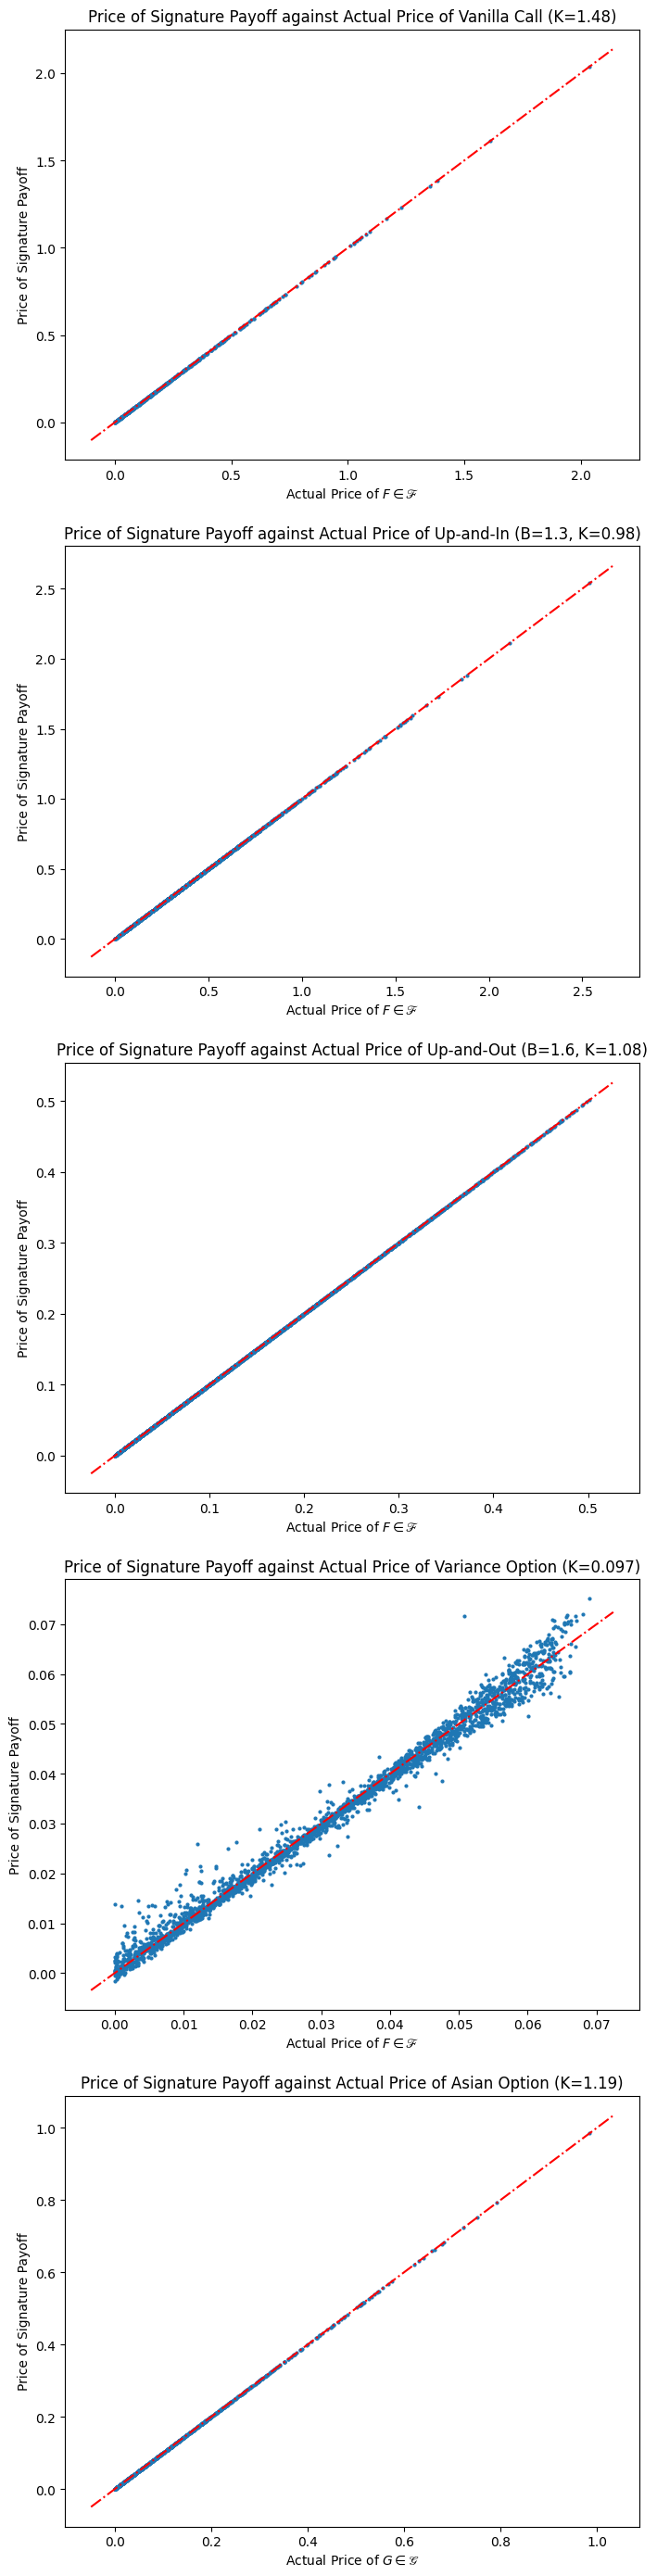

In [73]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 35))

signature_payoffs = []
for strike in np.linspace(1, 1.48, 25):
    payoffs = np.maximum(S_t[-1, :]-strike, 0)
    model = OLS(payoffs[payoffs > 0], temp[payoffs > 0])
    results = model.fit()
    signature_payoff = results.params
    signature_payoffs.append(signature_payoff)
print('Signature payoffs min:', np.vstack(signature_payoffs[-25:]).min(), ', max: ', np.vstack(signature_payoffs[-25:]).max())
axs[0].scatter(payoffs[payoffs > 0], model.predict(results.params), s=4)
(x1, x2) = axs[0].get_xlim()
axs[0].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[0].set_title('Price of Signature Payoff against Actual Price of Vanilla Call (K=1.48)')
axs[0].set_xlabel(r'Actual Price of $F \in \mathscr{F}$')
axs[0].set_ylabel(r'Price of Signature Payoff')

for barrier in np.linspace(1.1, 1.3, 5):
    for strike in np.linspace(barrier-0.4, barrier-0.32, 5):
        payoffs = ((max_S > barrier).astype(int)) * np.maximum(S_t[-1, :]-strike, 0)
        model = OLS(payoffs[payoffs > 0], temp[payoffs > 0])
        results = model.fit()
        signature_payoff = results.params
        signature_payoffs.append(signature_payoff)
print('Signature payoffs min:', np.vstack(signature_payoffs[-25:]).min(), ', max: ', np.vstack(signature_payoffs[-25:]).max())
axs[1].scatter(payoffs[payoffs > 0], model.predict(results.params), s=4)
(x1, x2) = axs[1].get_xlim()
axs[1].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[1].set_title('Price of Signature Payoff against Actual Price of Up-and-In (B=1.3, K=0.98)')
axs[1].set_xlabel(r'Actual Price of $F \in \mathscr{F}$')
axs[1].set_ylabel(r'Price of Signature Payoff')

for barrier in np.linspace(1.4, 1.6, 5):
    for strike in np.linspace(barrier-0.6, barrier-0.52, 5):
        payoffs = ((max_S < barrier).astype(int)) * np.maximum(S_t[-1, :] - strike, 0)
        model = OLS(payoffs[payoffs > 0], temp[payoffs > 0])
        results = model.fit()
        signature_payoff = results.params
        signature_payoffs.append(signature_payoff)
print('Signature payoffs min:', np.vstack(signature_payoffs[-25:]).min(), ', max: ', np.vstack(signature_payoffs[-25:]).max())
axs[2].scatter(payoffs[payoffs > 0], model.predict(results.params), s=4)
(x1, x2) = axs[2].get_xlim()
axs[2].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[2].set_title('Price of Signature Payoff against Actual Price of Up-and-Out (B=1.6, K=1.08)')
axs[2].set_xlabel(r'Actual Price of $F \in \mathscr{F}$')
axs[2].set_ylabel(r'Price of Signature Payoff')

log_ret = np.log(S_t[1:, :]/S_t[:-1, :])
realised_variance = (log_ret**2).sum(axis=0)
for variance in np.linspace(0.001, 0.097, 25):
    payoffs = np.maximum(realised_variance-variance, 0)
    model = OLS(payoffs[payoffs > 0], temp[payoffs > 0])
    results = model.fit()
    signature_payoff = results.params
    signature_payoffs.append(signature_payoff)
print('Signature payoffs min:', np.vstack(signature_payoffs[-25:]).min(), ', max: ', np.vstack(signature_payoffs[-25:]).max())
axs[3].scatter(payoffs[payoffs > 0], model.predict(results.params), s=4)
(x1, x2) = axs[3].get_xlim()
axs[3].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[3].set_title('Price of Signature Payoff against Actual Price of Variance Option (K=0.097)')
axs[3].set_xlabel(r'Actual Price of $F \in \mathscr{F}$')
axs[3].set_ylabel(r'Price of Signature Payoff')
signature_payoffs = np.vstack(signature_payoffs)

AS_signature_payoffs = []
for strike in np.linspace(0.70, 1.19, 50):
    payoffs = np.maximum(avg - strike, 0)
    model = OLS(payoffs[payoffs > 0], temp[payoffs > 0])
    results = model.fit()
    AS_signature_payoff = results.params
    AS_signature_payoffs.append(AS_signature_payoff)
print('Signature payoffs min:', np.vstack(AS_signature_payoffs).min(), ', max: ', np.vstack(AS_signature_payoffs).max())
axs[4].scatter(payoffs[payoffs > 0], np.dot(temp[payoffs > 0], AS_signature_payoff), s=4)
(x1, x2) = axs[4].get_xlim()
axs[4].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[4].set_title('Price of Signature Payoff against Actual Price of Asian Option (K=1.19)')
axs[4].set_xlabel(r'Actual Price of $G \in \mathscr{G}$')
axs[4].set_ylabel(r'Price of Signature Payoff')
AS_signature_payoffs = np.vstack(AS_signature_payoffs)

# Computing Implied Expected Signature

### Performing PCA to reduce multicollinearity in signature payoffs

Explained Variance Ratio: 
[0.98168092 0.99120039 0.99957924 0.99996519 0.99998955 0.9999957
 0.99999852 0.99999951 0.99999976 0.99999987 0.99999995 0.99999998
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


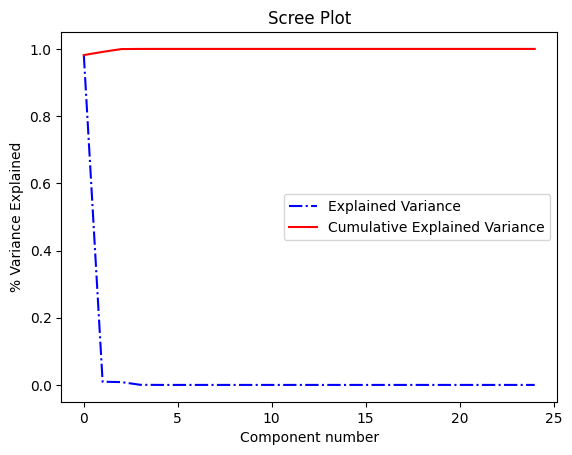

In [85]:
K1, K2 = 75, 100
X = signature_payoffs[K1:K2, :]

# Normalisation
X -= X.min(axis=0)
X = 2*np.divide(X, X.max(axis=0))-1

pca = PCA()
X = pca.fit_transform(X)
AS_signature_payoffs2 = pca.transform(AS_signature_payoffs)
plt.plot(pca.explained_variance_ratio_, linestyle='-.', c='b')
plt.plot(np.cumsum(pca.explained_variance_ratio_), c='r')
plt.title('Scree Plot')
plt.ylabel('% Variance Explained')
plt.xlabel('Component number')
plt.legend(['Explained Variance', 'Cumulative Explained Variance'])
print('Explained Variance Ratio: ')
print(np.cumsum(pca.explained_variance_ratio_))

### PCA fit

Implied expected signature min:  -40.33528961359574 , max:  25.68440157578932


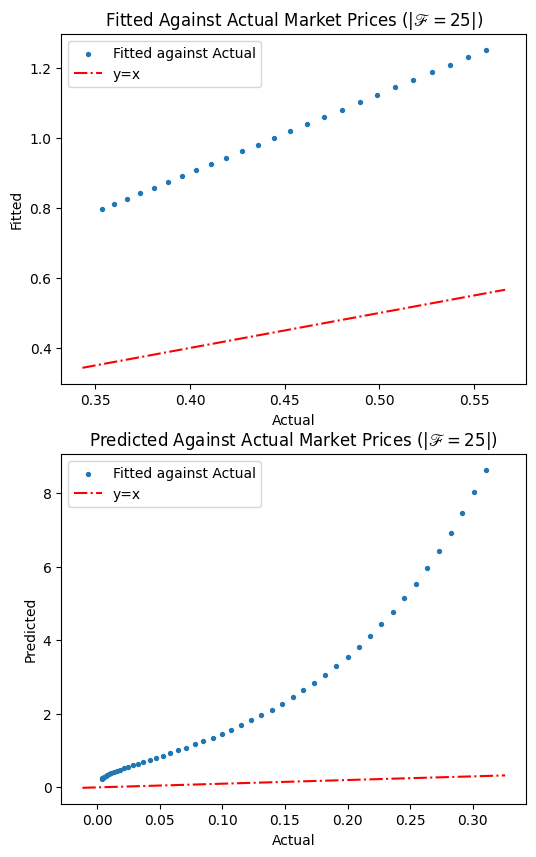

In [105]:
model = OLS(np.log(market.values[K1:K2]), X)
results = model.fit()
implied_expected_signature = results.params
print('Implied expected signature min: ', results.params.min(), ', max: ', results.params.max())
training_fit = np.exp(model.predict(implied_expected_signature))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

axs[0].scatter(market.values[K1:K2], training_fit, s=8)
(x1, x2) = axs[0].get_xlim()
axs[0].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[0].set_title(r'Fitted Against Actual Market Prices ($|\mathscr{F}=25|$)')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Fitted')
axs[0].legend(['Fitted against Actual', 'y=x'])

test_fit = np.exp(model.predict(implied_expected_signature, AS_signature_payoffs2))
axs[1].scatter(asian_option_df, test_fit, s=8)
(x1, x2) = axs[1].get_xlim()
axs[1].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[1].set_title(r'Predicted Against Actual Market Prices ($|\mathscr{F}=25|$)')
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('Predicted')
axs[1].legend(['Fitted against Actual', 'y=x']);

Implied expected signature min:  -7.0607980806806045 , max:  4.293241483119995


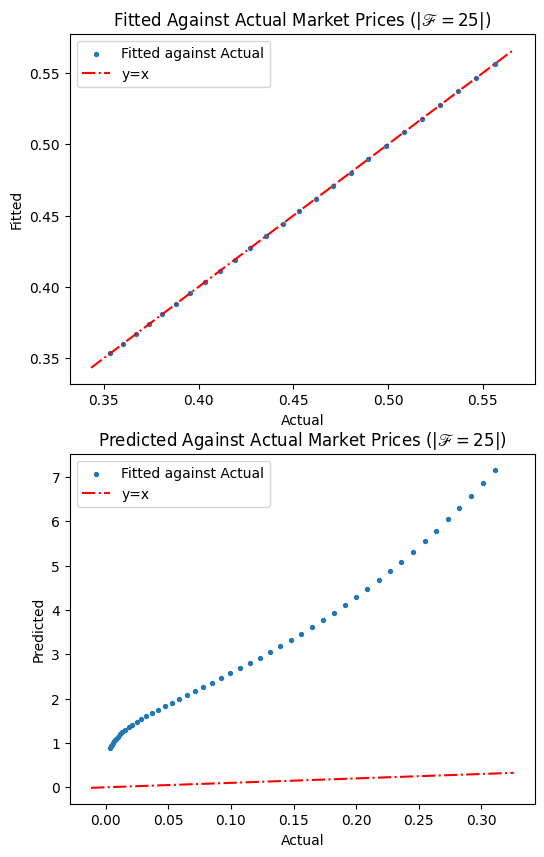

In [103]:
K1, K2 = 75, 100
model = OLS(np.log(market.values[K1:K2]), signature_payoffs[K1:K2, :])
results = model.fit()
implied_expected_signature = results.params
print('Implied expected signature min: ', results.params.min(), ', max: ', results.params.max())
training_fit = np.exp(model.predict(implied_expected_signature))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

axs[0].scatter(market.values[K1:K2], training_fit, s=8)
(x1, x2) = axs[0].get_xlim()
axs[0].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[0].set_title(r'Fitted Against Actual Market Prices ($|\mathscr{F}=25|$)')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Fitted')
axs[0].legend(['Fitted against Actual', 'y=x'])

test_fit = np.exp(model.predict(implied_expected_signature, AS_signature_payoffs))
axs[1].scatter(asian_option_df, test_fit, s=8)
(x1, x2) = axs[1].get_xlim()
axs[1].plot([x1, x2], [x1, x2], linestyle='-.', c='r')
axs[1].set_title(r'Predicted Against Actual Market Prices ($|\mathscr{F}=25|$)')
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('Predicted')
axs[1].legend(['Fitted against Actual', 'y=x']);